Downloading the dataset (https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/heart-attack-analysis-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\timmo\.cache\kagglehub\datasets\rashikrahmanpritom\heart-attack-analysis-prediction-dataset\versions\2


EDA

Information about dataset from discussion forum (as creater information wasn't complete) (https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843):
1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

Target = 0 means less chance of a heart attack, Target = 1 mean higher cance of a heart attack

In [44]:
import pandas as pd

df = pd.read_csv(f"{path}/heart.csv")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [46]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [47]:
for col in df.columns:
    print(f"{col}: minimum={df[col].min()}, maximum={df[col].max()}")

age: minimum=29, maximum=77
sex: minimum=0, maximum=1
cp: minimum=0, maximum=3
trtbps: minimum=94, maximum=200
chol: minimum=126, maximum=564
fbs: minimum=0, maximum=1
restecg: minimum=0, maximum=2
thalachh: minimum=71, maximum=202
exng: minimum=0, maximum=1
oldpeak: minimum=0.0, maximum=6.2
slp: minimum=0, maximum=2
caa: minimum=0, maximum=4
thall: minimum=0, maximum=3
output: minimum=0, maximum=1


The baseline is an accuracy of 54%.

In [48]:
df["output"].sum()/df["output"].count()

0.5445544554455446

All numerical features are normally distrubed except for the oldpeak. The old peak is a comparison between a ST segment (can be seen in a ECG)in rest and during/after exercise. A value of 0.0 mm means there will be no ST depression (this can induce heart failure) and how higher the value is, how higher the chans of an ST depression is. A value of 0 can thus be seen as "normal" and a value of 2.5 for example is more of an exception.

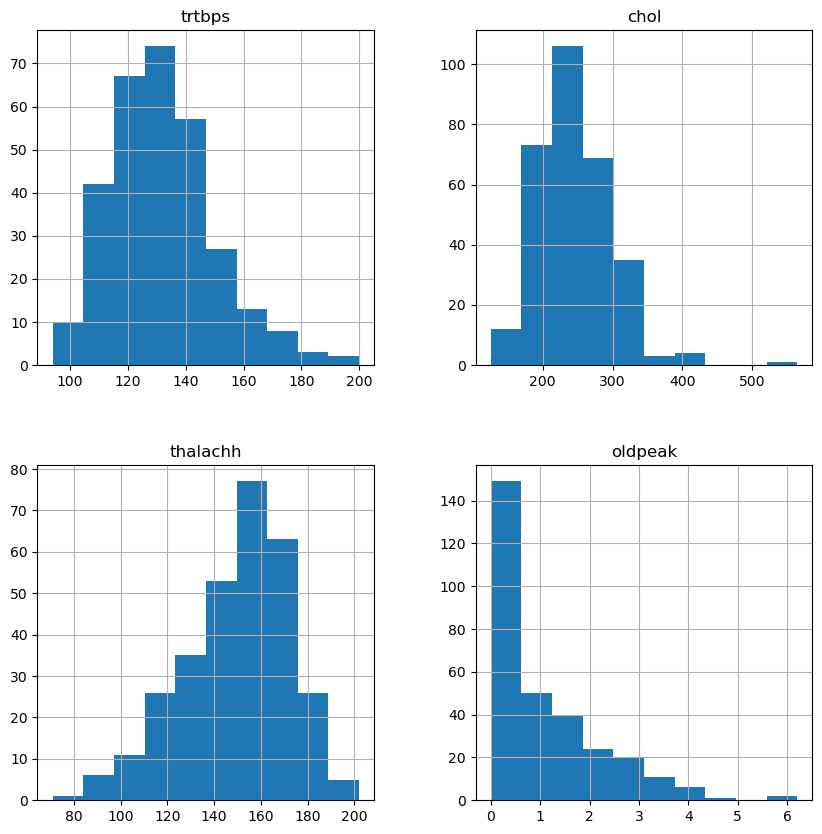

In [49]:
numerical_features = ["trtbps", "chol", "thalachh", "oldpeak"]
df[numerical_features].hist(figsize=(10, 10));

For the same reason as stated above the mean value of the oldpeak with a higher change of a heart attack is higher then with a lower heart attack.

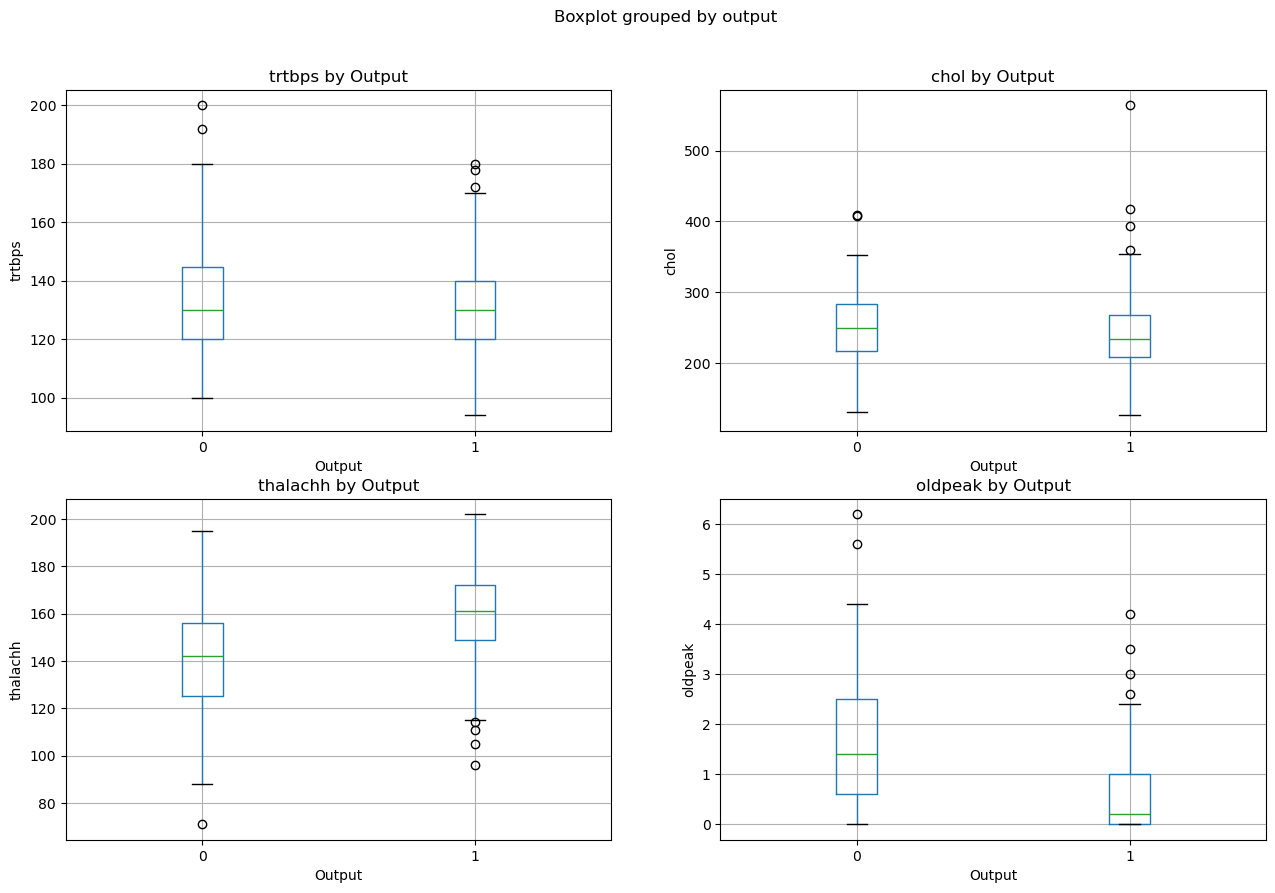

In [50]:
import matplotlib.pyplot as plt

figs, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axs[idx]
    df.boxplot(column=feature, by="output", ax=ax)
    ax.set_title(f"{feature} by Output")
    ax.set_xlabel("Output")
    ax.set_ylabel(feature)


The thalach feature (maximum heart rate achieved) has a declining trend over age.

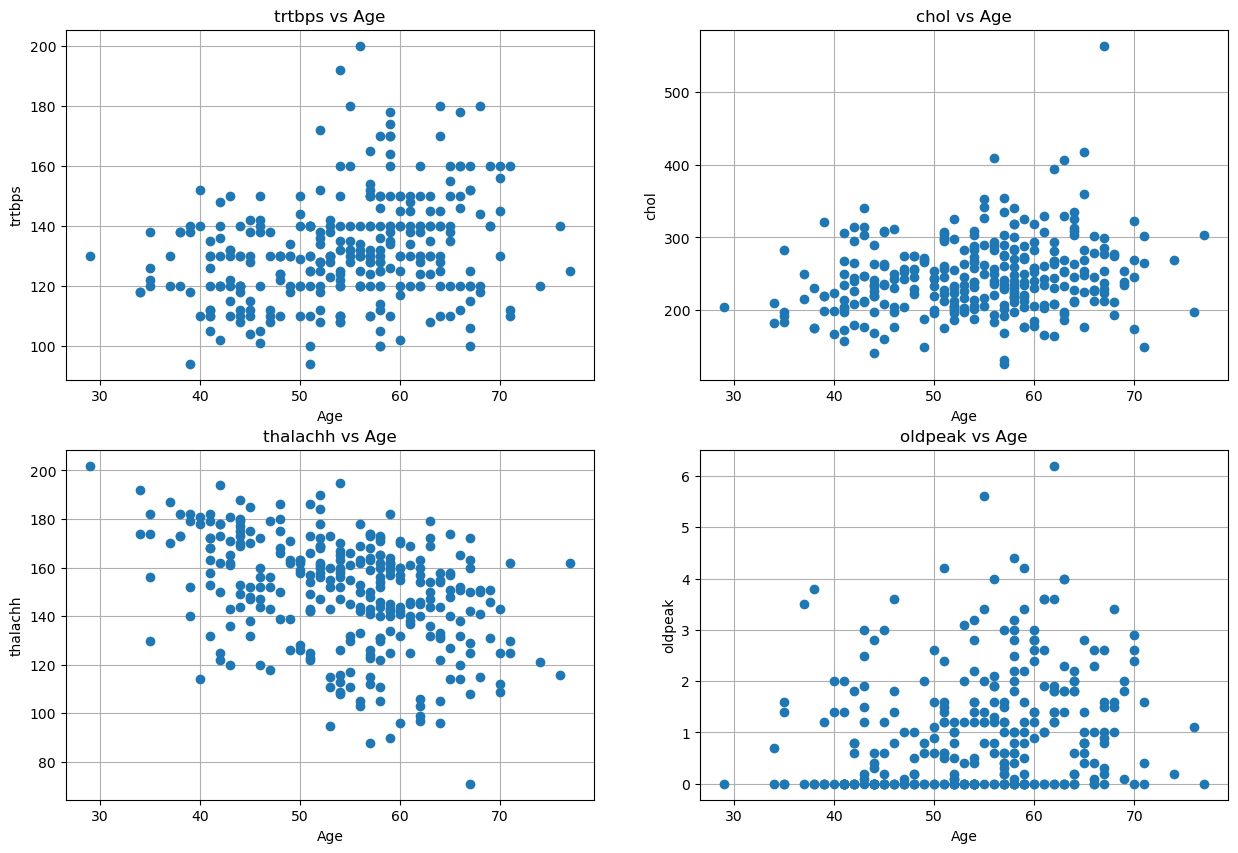

In [51]:
figs, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axs[idx]
    ax.plot(df["age"], df[feature], "o") 
    ax.set_title(f"{feature} vs Age") 
    ax.grid() 
    ax.set_xlabel("Age")  
    ax.set_ylabel(feature) 

### Modelling

To evaluate the models I have chosen for the accuracy and the F1-score. It is import that the predictions are as good as possible and have as less as false positives and false negatives as possible. 

In [52]:
from sklearn.model_selection import train_test_split

X = df.drop("output", axis=1)
y = df["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### XGBoost

This model is overfitted on the trainset it has a mean accuracy of 100% when the testset has a mean accuracy of 75%. It has a F1 score of 74% on the testset and a F1 score of 100% of the trainingset.

In [53]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test), xgb_model.score(X_train, y_train) # Mean accuracy

(0.7540983606557377, 1.0)

In [54]:
from sklearn.metrics import classification_report, f1_score

y_pred_test = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
y_pred_train = xgb_model.predict(X_train)
print(classification_report(y_train, y_pred_train))
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")
print(f"F1 Score train: {f1_score(y_train, y_pred_train)}")

              precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.73      0.76      0.75        29

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       136

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

F1 Score test: 0.7457627118644068
F1 Score train: 1.0


#### Logistic regression

This model has a mean accuracy of 85% on the trainingset and an higher mean accuracy of 80% on the testset. It has a F1 score of 81% on the testset and a F1 score of 88% on the trainingset.

In [55]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, solver="liblinear")
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test), lr_model.score(X_train, y_train) # Mean accuracy

(0.8032786885245902, 0.859504132231405)

In [56]:
y_pred_test = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
y_pred_train = lr_model.predict(X_train)
print(classification_report(y_train, y_pred_train))
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")
print(f"F1 Score train: {f1_score(y_train, y_pred_train)}")

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.74      0.90      0.81        29

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.82      0.80      0.80        61

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       106
           1       0.84      0.92      0.88       136

    accuracy                           0.86       242
   macro avg       0.86      0.85      0.86       242
weighted avg       0.86      0.86      0.86       242

F1 Score test: 0.8125
F1 Score train: 0.8802816901408451


### Random Forests

This model is overfitted on the trainset it has a mean accuracy of 100% when the testset has a mean accuracy of 78%. It has a F1 score of 78% on the testset and a F1 score of 100% on the trainingset.

In [57]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
rfc_model.score(X_test, y_test), rfc_model.score(X_train, y_train) # Mean accuracy


(0.7868852459016393, 1.0)

In [58]:
y_pred_test = rfc_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
y_pred_train = rfc_model.predict(X_train)
print(classification_report(y_train, y_pred_train))
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")
print(f"F1 Score train: {f1_score(y_train, y_pred_train)}")

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        32
           1       0.75      0.83      0.79        29

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       136

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

F1 Score test: 0.7868852459016393
F1 Score train: 1.0


## Hyperparameter tuning of logistic regression

Logistic regression isn't overfitted and has the highest mean accuracy on the testset of the 3 models I trained. 

In [59]:
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression(max_iter=1000, solver="liblinear")

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 0.625, 0.75, 0.875, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
}

grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_

print(f"Test Accuracy: {best_model.score(X_test, y_test)}")
print(f"Train Accuracy: {best_model.score(X_train, y_train)}")
print(f"F1 Score test: {f1_score(y_test, best_model.predict(X_test))}")
print(f"F1 Score train: {f1_score(y_train, best_model.predict(X_train))}")


Best Parameters: {'C': 0.5, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2'}
Best Cross-Validation Score: 0.8427721088435375
Test Accuracy: 0.8032786885245902
Train Accuracy: 0.8677685950413223
F1 Score test: 0.8125
F1 Score train: 0.8881118881118881


The hyperparamater tuning didn't improve the accuracy scores by a lot. The F1 scores are also relativly the same.